In [446]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import datetime as dt
import plotly.express as px

path = 'data_sher'


In [447]:

income_5 = pd.read_excel(f'{path}/05.2022_Выручка.xlsx')
pass_trafic_5 = pd.read_excel(f'{path}/05.2022_Пассажиропоток.xlsx')
flight_shedule = pd.read_excel(f'{path}/Расписание рейсов 05-06.2022.xlsx') # Данные за 2 месяца
manual_airports = pd.read_excel(f'{path}/Справочник_AIRPORTS.xlsx')
manual_airlines = pd.read_excel(f'{path}/Справочник_AIRLINES.xlsx')
weather = pd.read_csv(f'{path}/Moscow_2022-05-01_to_2022-05-31.csv')

In [448]:
income_5 = pd.read_excel(f'{path}/06.2022_Выручка.xlsx')
pass_trafic_5 = pd.read_excel(f'{path}/06.2022_Пассажиропоток.xlsx')
weather = pd.read_csv(f'{path}/Moscow 2022-05-28 to 2022-07-03.csv')

In [449]:
income_5['Точка продаж'].value_counts()

Точка продаж 3     1401
Точка продаж 28    1398
Точка продаж 5     1397
Точка продаж 8     1392
Точка продаж 23    1388
Точка продаж 12    1372
Точка продаж 19    1361
Точка продаж 4     1357
Точка продаж 24    1354
Точка продаж 10    1353
Точка продаж 9     1353
Точка продаж 25    1345
Точка продаж 2     1334
Точка продаж 22    1284
Точка продаж 16    1272
Точка продаж 13    1066
Точка продаж 15     962
Точка продаж 27     955
Точка продаж 7      949
Точка продаж 11     874
Точка продаж 17     641
Точка продаж 30     623
Точка продаж 6      608
Точка продаж 1      562
Точка продаж 21     501
Точка продаж 14     441
Точка продаж 26     241
Name: Точка продаж, dtype: int64

In [450]:
# Task 1 WEATHER
# 1) Make connection to weather lib 
# 2) make new categorical column that will be represent weater state with OneHoteEncoding for each time period in Moscow
# 3) Make 1-2 steps for 6 month 

weather = weather[['datetime', 'windgust', 'windspeed', 'visibility']]
weather = weather.astype({'datetime':'datetime64'})
weather['datetime'] = weather['datetime'].dt.strftime("%y-%m-%d %H")
df = income_5.copy() # Final dataset which will be contain all columns to make a predict
df = df.astype({'Дата с разбивкой по 30 минут':'datetime64'})
df['date_on_hour'] = df['Дата с разбивкой по 30 минут'].dt.strftime("%y-%m-%d %H")
df = df.merge(weather, left_on = 'date_on_hour', right_on = 'datetime') #27356
df = df.drop(columns = ['date_on_hour','datetime'])
df

,Дата,Дата с разбивкой по 30 минут,Прибыль на момент времени,Точка продаж,windgust,windspeed,visibility
0,2022-05-31,2022-05-31 23:30:00,540,Точка продаж 15,5.4,6.6,6.2
1,2022-05-31,2022-05-31 23:30:00,438.5,Точка продаж 5,5.4,6.6,6.2
2,2022-06-01,2022-06-01 00:00:00,290,Точка продаж 14,5.8,5.1,4.5
3,2022-06-01,2022-06-01 00:00:00,3 125,Точка продаж 19,5.8,5.1,4.5
4,2022-06-01,2022-06-01 00:00:00,3 845,Точка продаж 16,5.8,5.1,4.5
...,...,...,...,...,...,...,...
28779,2022-07-01,2022-07-01 00:00:00,2 053,Точка продаж 8,8.6,11.4,10.0
28780,2022-07-01,2022-07-01 00:00:00,54,Точка продаж 22,8.6,11.4,10.0
28781,2022-07-01,2022-07-01 00:00:00,508,Точка продаж 12,8.6,11.4,10.0
28782,2022-07-01,2022-07-01 00:00:00,197.5,Точка продаж 24,8.6,11.4,10.0


In [451]:
# Task 2, period of day: morning [6- 12], middle [13-18], evening [19-00], night[00 - 05]
def make_periods(x):
    if 13 <= x <= 19:
        return 'middle_day'
    if 19 <= x <= 23:
        return 'evening'
    return 'night'
df['day_period'] = df['Дата с разбивкой по 30 минут'].dt.hour
df['day_period'] = df['day_period'].apply(lambda x: make_periods(x))
df = df.merge(pd.get_dummies(df['day_period']), left_index=True, right_index=True).drop(columns = ['day_period'])
df

,Дата,Дата с разбивкой по 30 минут,Прибыль на момент времени,Точка продаж,windgust,windspeed,visibility,evening,middle_day,night
0,2022-05-31,2022-05-31 23:30:00,540,Точка продаж 15,5.4,6.6,6.2,1,0,0
1,2022-05-31,2022-05-31 23:30:00,438.5,Точка продаж 5,5.4,6.6,6.2,1,0,0
2,2022-06-01,2022-06-01 00:00:00,290,Точка продаж 14,5.8,5.1,4.5,0,0,1
3,2022-06-01,2022-06-01 00:00:00,3 125,Точка продаж 19,5.8,5.1,4.5,0,0,1
4,2022-06-01,2022-06-01 00:00:00,3 845,Точка продаж 16,5.8,5.1,4.5,0,0,1
...,...,...,...,...,...,...,...,...,...,...
28779,2022-07-01,2022-07-01 00:00:00,2 053,Точка продаж 8,8.6,11.4,10.0,0,0,1
28780,2022-07-01,2022-07-01 00:00:00,54,Точка продаж 22,8.6,11.4,10.0,0,0,1
28781,2022-07-01,2022-07-01 00:00:00,508,Точка продаж 12,8.6,11.4,10.0,0,0,1
28782,2022-07-01,2022-07-01 00:00:00,197.5,Точка продаж 24,8.6,11.4,10.0,0,0,1


In [452]:
# Task 3, determine number of flights
# Create a column ['flight_count'], that will be contain number of flights. Flight will be count, if time before flight in interbal [4 hours - 30 min]
flight_shedule_5 = flight_shedule[flight_shedule['FLIGHT_DATE'].dt.month == 5]
def flight_count(x, left_corn = 4 * 60, right_corn = 30):
    l_cor = x - dt.timedelta(minutes = left_corn)
    r_cor = x - dt.timedelta(minutes = right_corn)
    return flight_shedule_5[(flight_shedule_5.OUT_BEST_TIME.dt.day == x.day) & \
                     (flight_shedule_5.OUT_BEST_TIME >= l_cor) &\
                    (flight_shedule_5.OUT_BEST_TIME <= r_cor)].shape[0]

flight_shedule_5 = flight_shedule[flight_shedule['FLIGHT_DATE'].dt.month == 5]
min_data = min(df['Дата с разбивкой по 30 минут'])
max_data = max(df['Дата с разбивкой по 30 минут'])
df_times = pd.DataFrame(pd.date_range(start = min_data,end= max_data, freq = '30min'))
df_times['flight_count'] = df_times[0].apply(lambda x: flight_count(x))
df = df.merge(df_times, left_on = 'Дата с разбивкой по 30 минут', right_on = 0).drop(columns = [0])
df

,Дата,Дата с разбивкой по 30 минут,Прибыль на момент времени,Точка продаж,windgust,windspeed,visibility,evening,middle_day,night,flight_count
0,2022-05-31,2022-05-31 23:30:00,540,Точка продаж 15,5.4,6.6,6.2,1,0,0,41
1,2022-05-31,2022-05-31 23:30:00,438.5,Точка продаж 5,5.4,6.6,6.2,1,0,0,41
2,2022-06-01,2022-06-01 00:00:00,290,Точка продаж 14,5.8,5.1,4.5,0,0,1,0
3,2022-06-01,2022-06-01 00:00:00,3 125,Точка продаж 19,5.8,5.1,4.5,0,0,1,0
4,2022-06-01,2022-06-01 00:00:00,3 845,Точка продаж 16,5.8,5.1,4.5,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
28779,2022-07-01,2022-07-01 00:00:00,2 053,Точка продаж 8,8.6,11.4,10.0,0,0,1,0
28780,2022-07-01,2022-07-01 00:00:00,54,Точка продаж 22,8.6,11.4,10.0,0,0,1,0
28781,2022-07-01,2022-07-01 00:00:00,508,Точка продаж 12,8.6,11.4,10.0,0,0,1,0
28782,2022-07-01,2022-07-01 00:00:00,197.5,Точка продаж 24,8.6,11.4,10.0,0,0,1,0


In [453]:
# Correct income to float format
df['Прибыль на момент времени'] = df['Прибыль на момент времени'].str.replace('\s','',regex = True).fillna(df['Прибыль на момент времени'])
df['Прибыль на момент времени'] = df['Прибыль на момент времени'].str.replace(',','.',regex = True).fillna(df['Прибыль на момент времени']).astype('float64')

In [454]:
# Correct sale spot columns name
df['Точка продаж'] = df['Точка продаж'].str.replace('Точка продаж', '').astype('int32')
df

,Дата,Дата с разбивкой по 30 минут,Прибыль на момент времени,Точка продаж,windgust,windspeed,visibility,evening,middle_day,night,flight_count
0,2022-05-31,2022-05-31 23:30:00,540.0,15,5.4,6.6,6.2,1,0,0,41
1,2022-05-31,2022-05-31 23:30:00,438.5,5,5.4,6.6,6.2,1,0,0,41
2,2022-06-01,2022-06-01 00:00:00,290.0,14,5.8,5.1,4.5,0,0,1,0
3,2022-06-01,2022-06-01 00:00:00,3125.0,19,5.8,5.1,4.5,0,0,1,0
4,2022-06-01,2022-06-01 00:00:00,3845.0,16,5.8,5.1,4.5,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
28779,2022-07-01,2022-07-01 00:00:00,2053.0,8,8.6,11.4,10.0,0,0,1,0
28780,2022-07-01,2022-07-01 00:00:00,54.0,22,8.6,11.4,10.0,0,0,1,0
28781,2022-07-01,2022-07-01 00:00:00,508.0,12,8.6,11.4,10.0,0,0,1,0
28782,2022-07-01,2022-07-01 00:00:00,197.5,24,8.6,11.4,10.0,0,0,1,0


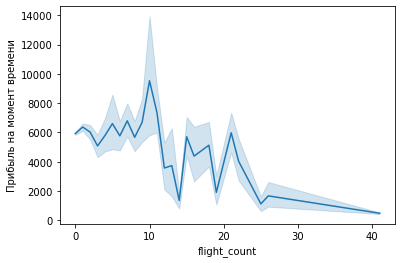

In [455]:
# Can see,that income increase really much after 28 flights
df_12 = df[['flight_count', 'Прибыль на момент времени']]
sns.lineplot(data = df_12, x ='flight_count', y = "Прибыль на момент времени")
df['flight_count'] = df['flight_count'].apply(lambda x: 1 if x >= 28 else 0) # Transform quantitive variable to categorical

In [456]:
df12 = df_12.groupby('flight_count').mean().reset_index()
px.line(data_frame = df12, x = 'flight_count', y = 'Прибыль на момент времени')

In [457]:
af = manual_airports.copy()
af = af.assign(RU=af["NAME"].str.contains(r"\bРоссия", regex=True))
ru_data = set(af.loc[af["RU"] == 1]["IATACODE"].array)

uniq_traf = pass_trafic_5.copy()
uniq_traf["RU"] = uniq_traf["Направление куда летит"].apply(lambda x: x in ru_data)
uniq_traf = uniq_traf.groupby(['Выход на рейс', 'Рейс', "RU"]).agg(count=('Терминал', len), gate=('Терминал', max),
                                                                   ru_server=("RU", sum))
uniq_traf = uniq_traf.reset_index()
# uniq_traf = uniq_traf.merge(uniq_traf_, on = 'Выход на рейс').drop(columns = ['RU', 'gate_y','count_y'])
# uniq_traf
uniq_traf
# make 2 new columns: terminalA, terminalB. In each column I'll write number of flights in each termnial

,Выход на рейс,Рейс,RU,count,gate,ru_server
0,2022-06-01 00:00:00,SU 1478,True,159,B,159
1,2022-06-01 00:14:00,WZ 5081,False,416,C,0
2,2022-06-01 00:24:00,5N 237,True,190,B,190
3,2022-06-01 00:26:00,SU 046,True,77,B,77
4,2022-06-01 00:27:00,SU 1428,True,155,B,155
...,...,...,...,...,...,...
1271,2022-06-30 08:36:00,SU 1486,True,1,B,1
1272,2022-06-30 08:42:00,SU 1366,True,1,B,1
1273,2022-06-30 08:54:00,SU 1460,True,2,B,2
1274,2022-06-30 10:03:00,SU 1610,True,2,B,2


In [435]:
# Conncect these columns to main df
df_5_intervals =pd.DataFrame(pd.date_range(start = min_data,end= max_data, freq = '30min'))
df_flights = pd.DataFrame()
i = 0
for date in df_5_intervals[0]:
    l_cor = date - dt.timedelta(hours = 4)
    r_cor = date - dt.timedelta(minutes = 30) 
    flights_data = uniq_traf[(uniq_traf['Выход на рейс'] >= l_cor) & (uniq_traf['Выход на рейс'] <= r_cor)][['count', 'gate','ru_server']]
    flights_data = flights_data.groupby('gate').sum().reset_index()
    
    if flights_data.shape[0] == 0:
        flights_data  = pd.DataFrame({'gate':['B','C'], 'count':[0,0]})
    flights_data['datetime'] = date
   
    df_flights = df_flights.append(flights_data)
df_flights['gate'] = df_flights['gate'].apply(lambda x: 0 if x == 'B' else 1)
df = df.merge(df_flights,left_on = 'Дата с разбивкой по 30 минут', right_on = 'datetime')
df

,Дата,Дата с разбивкой по 30 минут,Прибыль на момент времени,Точка продаж,windgust,windspeed,visibility,evening,middle_day,night,flight_count,gate,count,datetime,ru_server
0,2022-05-31,2022-05-31 23:30:00,540.0,15,5.4,6.6,6.2,1,0,0,1,0,0,2022-05-31 23:30:00,NaN
1,2022-05-31,2022-05-31 23:30:00,540.0,15,5.4,6.6,6.2,1,0,0,1,1,0,2022-05-31 23:30:00,NaN
2,2022-05-31,2022-05-31 23:30:00,438.5,5,5.4,6.6,6.2,1,0,0,1,0,0,2022-05-31 23:30:00,NaN
3,2022-05-31,2022-05-31 23:30:00,438.5,5,5.4,6.6,6.2,1,0,0,1,1,0,2022-05-31 23:30:00,NaN
4,2022-06-01,2022-06-01 00:00:00,290.0,14,5.8,5.1,4.5,0,0,1,0,0,0,2022-06-01 00:00:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50066,2022-07-01,2022-07-01 00:00:00,508.0,12,8.6,11.4,10.0,0,0,1,0,1,0,2022-07-01 00:00:00,NaN
50067,2022-07-01,2022-07-01 00:00:00,197.5,24,8.6,11.4,10.0,0,0,1,0,0,0,2022-07-01 00:00:00,NaN
50068,2022-07-01,2022-07-01 00:00:00,197.5,24,8.6,11.4,10.0,0,0,1,0,1,0,2022-07-01 00:00:00,NaN
50069,2022-07-01,2022-07-01 00:30:00,8710.0,11,8.6,11.4,10.0,0,0,1,0,0,0,2022-07-01 00:30:00,NaN


In [436]:
# Transform double rows (one row contains data about gate B, another aboute gate C) to 1 row 2 columns (1 column gateB, another gate C)

#Add new column, that contains sum data of two gates
df = df.merge(df.groupby(['Точка продаж','Дата с разбивкой по 30 минут'])['count'].sum(),left_on = ['Точка продаж','Дата с разбивкой по 30 минут'], right_index = True)
#Change value in last column to contains data about First gate passanger traffic 
df = df.drop(columns = ['gate', 'datetime']).rename(columns = {'count_x':'count_B', 'count_y':'count_C'})
df['count_C'] = df['count_C'] - df['count_B']
# Drop surplus columns and rename columns to determ their meaning 
# avoid surplus rows
df = df.drop_duplicates(subset = ['Дата с разбивкой по 30 минут','Точка продаж'])

In [437]:
df = df.merge(pd.get_dummies(df['Точка продаж']),left_index = True, right_index = True)
df = df.drop(columns = ['Точка продаж'])

In [438]:
prodcal = pd.read_csv(f'{path}/data-20181017t0930-structure-20181017t0930_5.csv')
# TASK weekday
def weekday(mydate):
    # 4/30/2022
    mydate = mydate.to_pydatetime().date()
    month = {"1": "Январь", "2": "Февраль", "3": "Март", "4": "Апрель", "5": "Май", "6": "Июнь", "7": "Июль",
             "8": "Август", "9": "Сентябрь", "10": "Октябрь", "11": "Ноябрь", "12": "Декабрь"}
    prod_local = prodcal.loc[prodcal["Год/Месяц"].isin([int(mydate.year)])][month[str(mydate.month)]].array[0].split(",")
    return 1 if str(mydate.day) in prod_local else 0
df = df.assign(Weekday=df['Дата'].apply(lambda x: weekday(x)))


In [439]:
X = df.drop(columns=['flight_count']).iloc[:, 4:]
y = df.iloc[:, 2]
X 

,windspeed,visibility,evening,middle_day,night,count_B,ru_server,count_C,1,2,...,21,22,23,24,25,26,27,28,30,Weekday
0,6.6,6.2,1,0,0,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6.6,6.2,1,0,0,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.1,4.5,0,0,1,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,5.1,4.5,0,0,1,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5.1,4.5,0,0,1,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50061,11.4,10.0,0,0,1,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50063,11.4,10.0,0,0,1,0,NaN,0,0,0,...,0,1,0,0,0,0,0,0,0,0
50065,11.4,10.0,0,0,1,0,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50067,11.4,10.0,0,0,1,0,NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [442]:
X = X.fillna(0)

In [444]:

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.46933314064664156

In [469]:
pd.Series(abs(reg.predict(X))).to_excel('6_predict.xlsx')

In [464]:
len_plot = len(X.columns[8:-1])

In [463]:
len_data = len(pd.date_range(start = min_data,end= max_data, freq = '30min'))

array([13600.51312256,  9942.26153564,  3801.42224121, ...,
        5640.41638184,   960.49749756,  1706.89758301])